In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import yfinance as yf
from caviar import CaviarModel
from var_tests import *
import matplotlib.pyplot as plt

In [2]:
df = yf.download("AAPL JPM SPY XOM COKE", start="2001-01-01")

[*********************100%***********************]  5 of 5 completed


In [3]:
df_log_ret = df.Close.apply(np.log).diff().dropna() * 100
df_log_ret

,AAPL,COKE,JPM,SPY,XOM
Date,,,,,
2001-01-03,9.607481,0.339559,14.025589,4.691692,-4.445176
2001-01-04,4.112798,0.675678,2.679819,-1.082224,-2.825467
2001-01-05,-4.112798,1.669488,-6.069974,-3.318770,0.451468
2001-01-08,1.138456,3.257617,0.636539,0.771088,-0.451468
2001-01-09,3.704219,-3.092191,-1.148704,-0.264391,-1.061420
...,...,...,...,...,...
2023-03-31,1.552310,0.355724,1.204367,1.399622,0.155150
2023-04-03,0.767216,1.022637,-0.115172,0.380330,5.732553
2023-04-04,-0.325494,-3.910241,-1.345836,-0.556357,-0.960423


## Emperical Analysis - Implementation (SPY)

In [4]:
quantiles = [0.01, 0.05]
models = ['adaptive', 'asymmetric', 'symmetric', 'igarch']
tickers = ['SPY'] # df_log_ret.columns

Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 1514.2518758462177
Update 1: 0.0411022419581928
Update 2: 0.0411022419581928
Final loss: 0.0411022419581928
Time taken(s): 0.27
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 0.7304483534509398
Update 1: 0.03347181218070447
Update 2: 0.03347181218070447
Final loss: 0.03347181218070447
Time taken(s): 1.82
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 1.728936801539313
Update 1: 0.034447835802620015
Update 2: 0.03444780619011526
Update 3: 0.03444780617589343
Final loss: 0.03444780617589343
Time taken(s): 1.02
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 0.05311732206397447
Update 1: 0.034214522338111515
Update 2: 0.03421450595340073
Update 3: 0.03421450595190494
Final loss: 0.03421450595190494
Time taken(s): 1.52
Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 334.98700277906045
Upd

..\var_tests\_test.py:77: RuntimeWarning: invalid value encountered in double_scalars
  LR_POF = -2 * np.log(numerator / denominator)


Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 1.488786728213378
Update 1: 0.12672693997633072
Update 2: 0.12672693309926894
Update 3: 0.12672693309118024
Final loss: 0.12672693309118024
Time taken(s): 0.80


..\caviar\_utils.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
..\var_tests\_test.py:77: RuntimeWarning: invalid value encountered in double_scalars
  LR_POF = -2 * np.log(numerator / denominator)


Generating 1 best initial betas out of 1...
Optimizing...
when m = 1
Update 0: 0.18165132882945326
Update 1: 0.12624960717932684
Update 2: 0.12624941835187825
Update 3: 0.1262494183418476
Final loss: 0.1262494183418476
Time taken(s): 0.90


..\var_tests\_test.py:77: RuntimeWarning: invalid value encountered in double_scalars
  LR_POF = -2 * np.log(numerator / denominator)


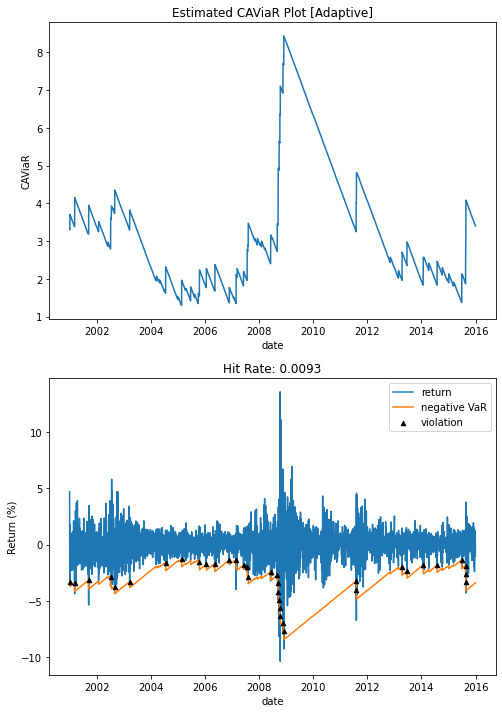

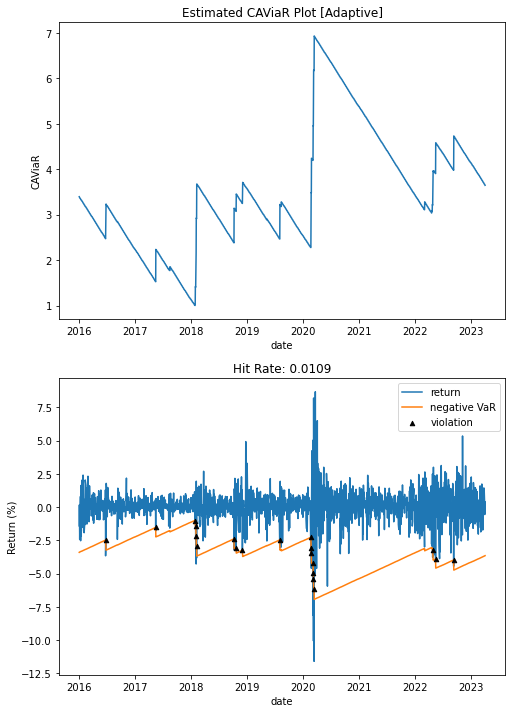

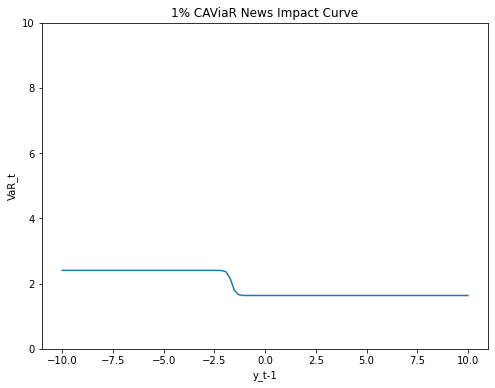

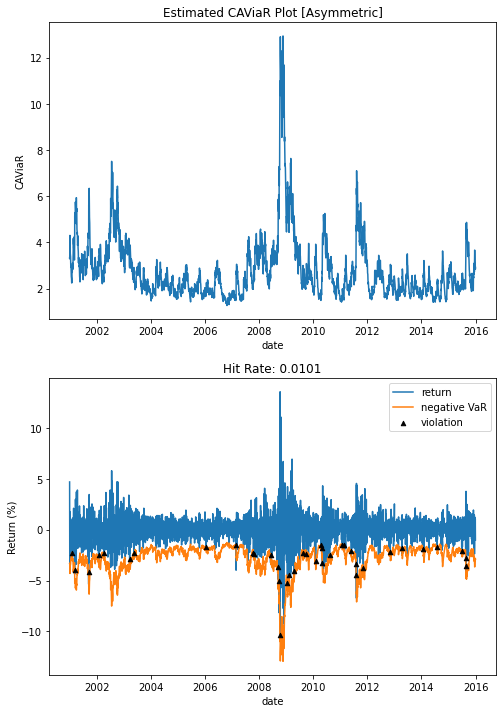

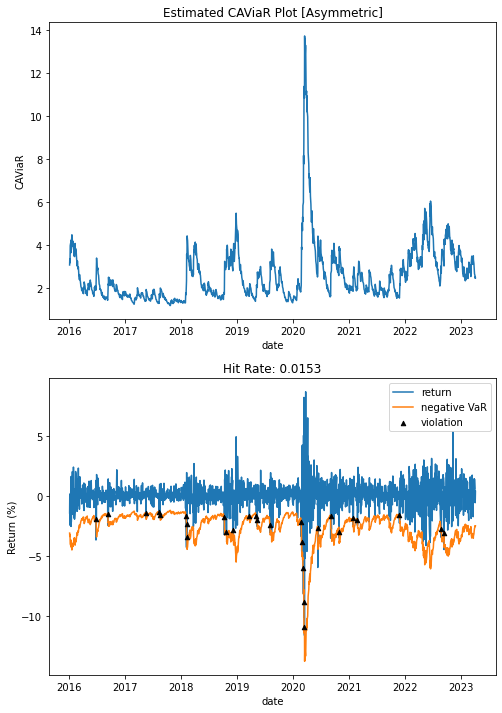

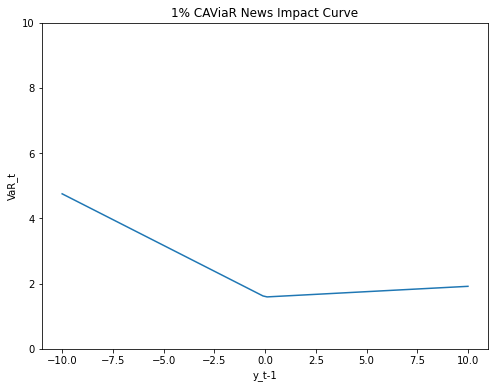

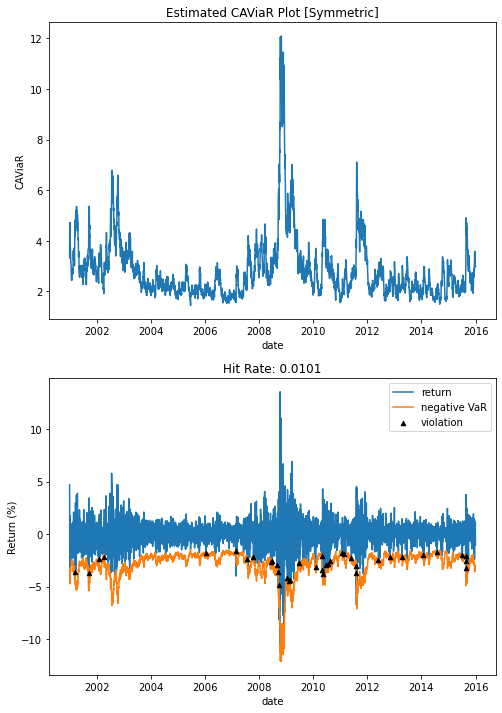

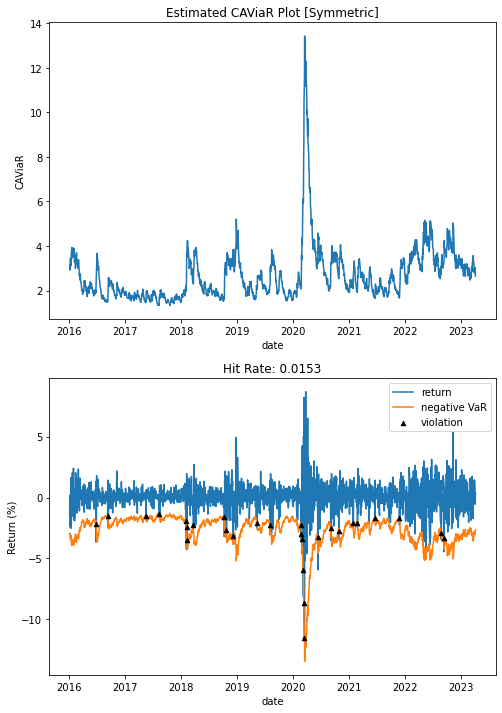

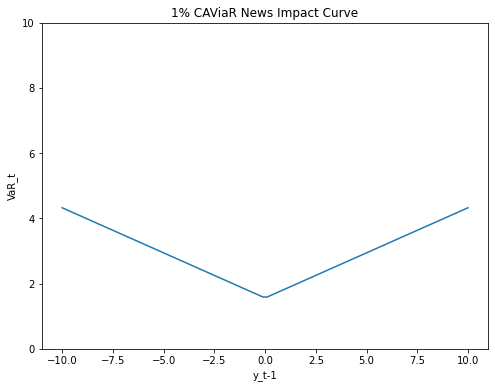

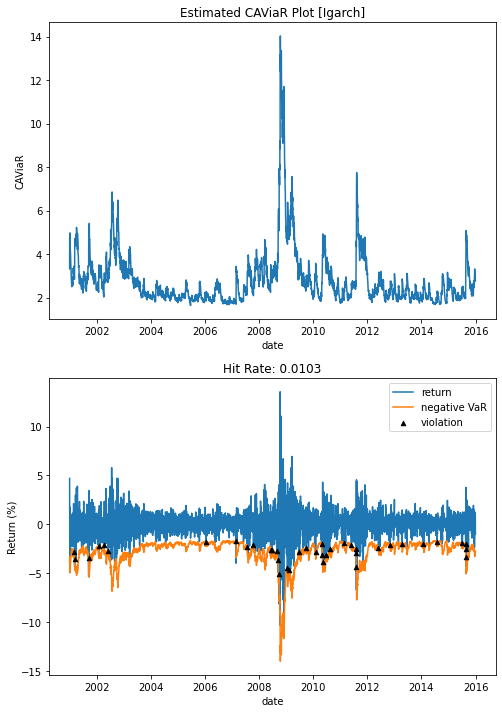

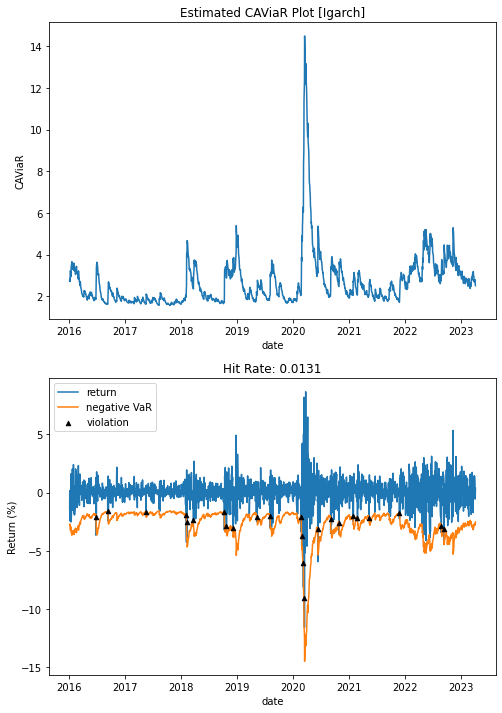

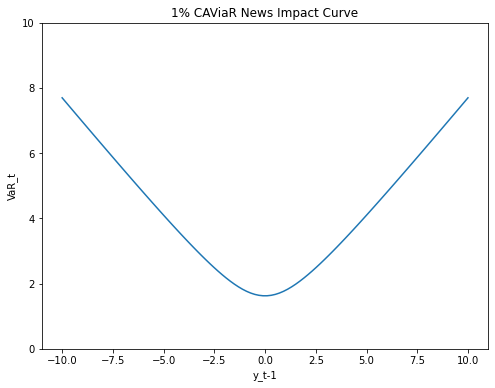

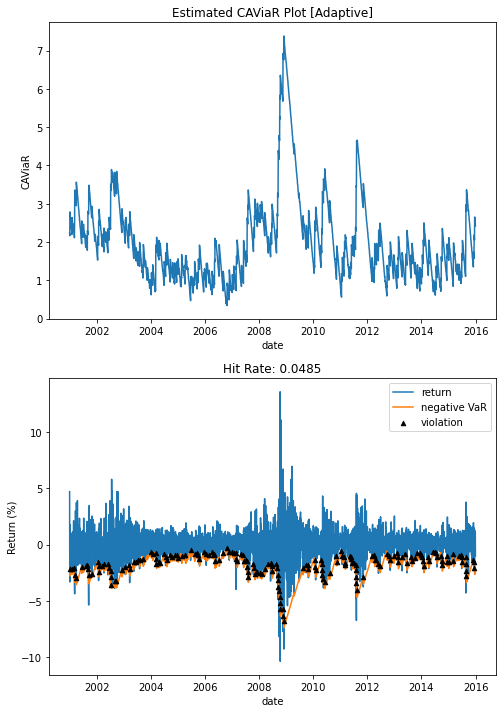

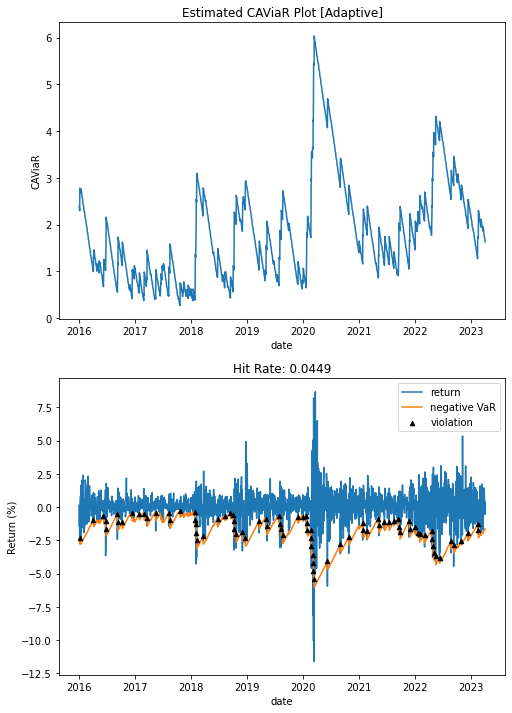

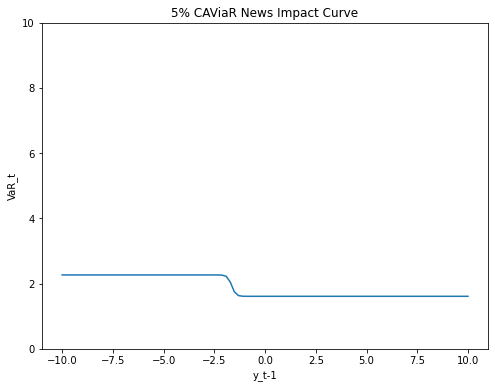

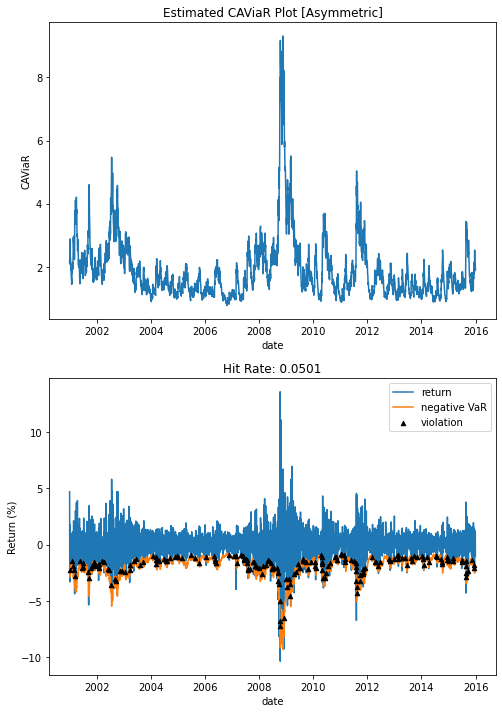

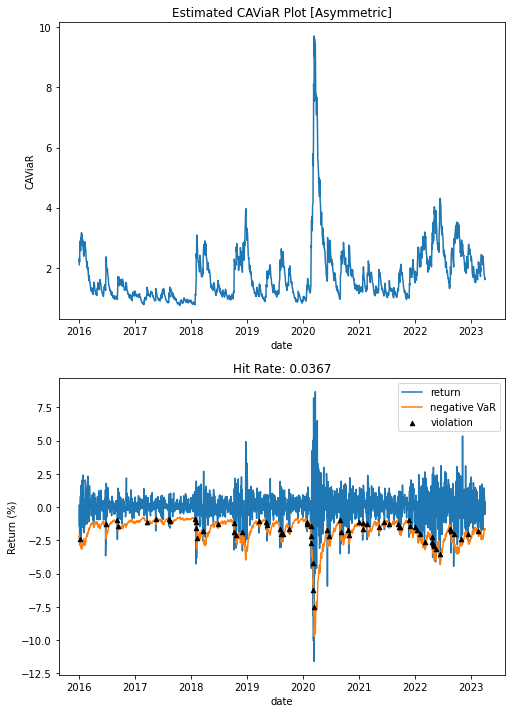

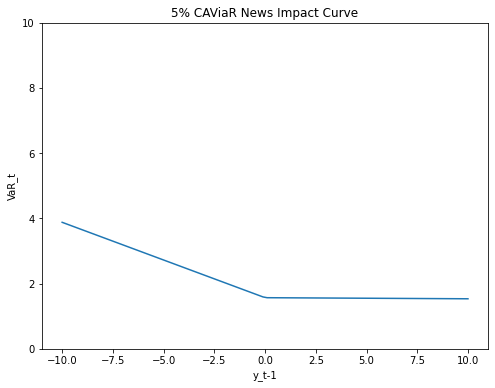

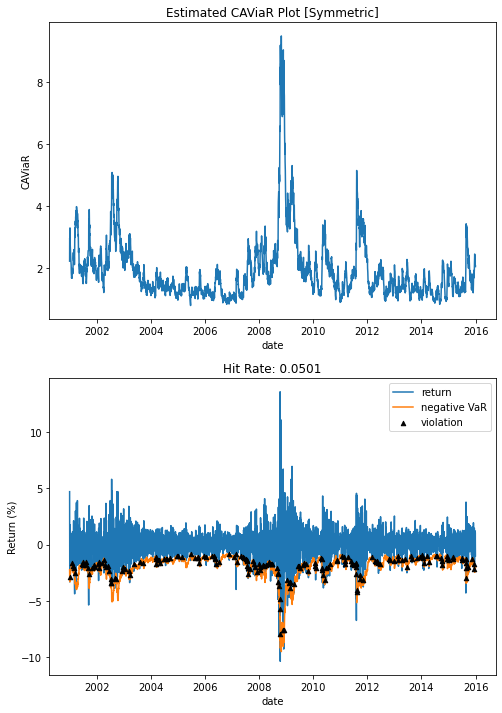

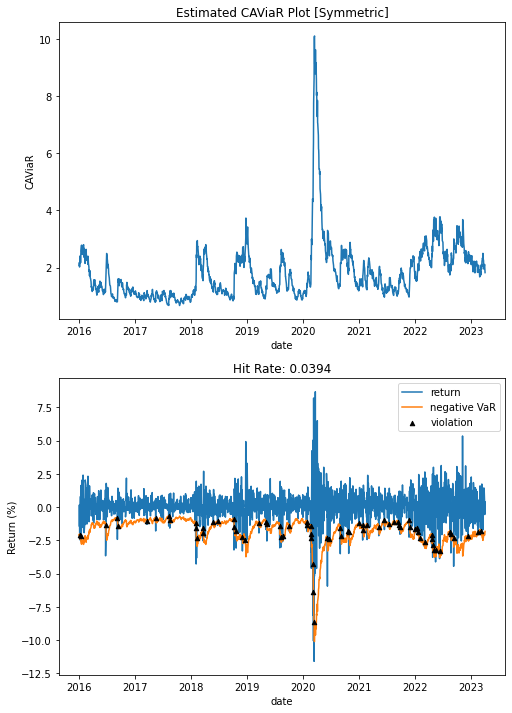

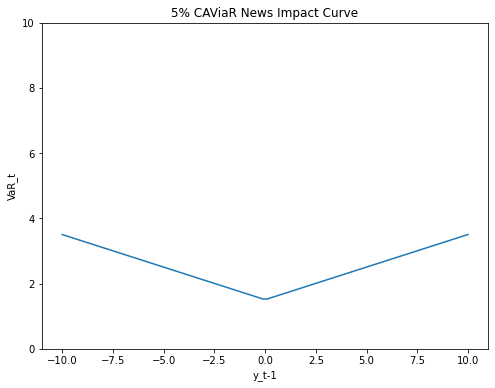

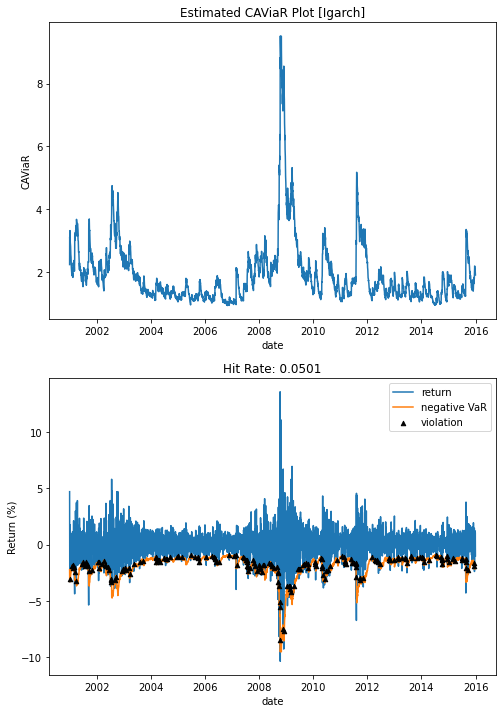

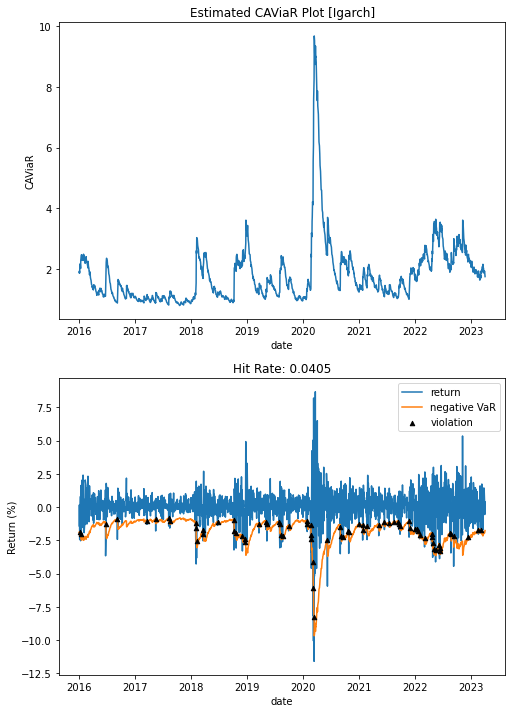

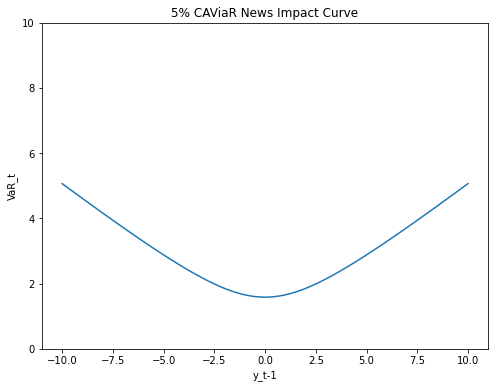

In [5]:
stats_df = []
beta_stats_df = []

save_csv_path = '../result/implementation1_spy'
save_plot_path = '../result/implementation1_spy/plots'

for ticker in tickers:
    in_samples = df_log_ret.loc[:'2015', ticker]
    out_samples = df_log_ret.loc['2016':, ticker]
    
    for q in quantiles:
        for model in models:
            caviar_model = CaviarModel(quantile=q, model=model, method='RQ')
            caviar_model.fit(in_samples)
            
            # save plots
            fig1 = caviar_model.plot_caviar(in_samples, 'in')
            plt.savefig(f'{save_plot_path}/{model}_{int(q*100)}%_plt_caviar_in.jpg')
            fig2 = caviar_model.plot_caviar(out_samples, 'out')
            plt.savefig(f'{save_plot_path}/{model}_{int(q*100)}%_plt_caviar_out.jpg')
            fig3 = caviar_model.plot_news_impact_curve()
            plt.savefig(f'{save_plot_path}/{model}_{int(q*100)}%_plt_news_impact_curve.jpg')
                        
            # as the last prediction is the VaR forecast
            in_VaR = caviar_model.predict(in_samples, 'in')[:-1]
            out_VaR = caviar_model.predict(out_samples, 'out')[:-1]

            # statistics
            stat = {
                'quantile': q,
                'model': model,
                'method': 'RQ',
                # 'trial': i,
                
                # insamples
                'loss': caviar_model.training_loss,
                'hit_rate_in': hit_rate(in_samples, in_VaR),
                'binom_in': binomial_test(in_samples, in_VaR, q),
                'traffic_in': traffic_light_test(in_samples, in_VaR, q)[0],
                'kupiec_in': kupiec_pof_test(in_samples, in_VaR, q),
                'independent_in': christoffersen_test(in_samples, in_VaR),
                'dq_in': caviar_model.dq_test(in_samples, 'in'),
                # outsamples
                'hit_rate_out': hit_rate(out_samples, out_VaR),
                'binom_out': binomial_test(out_samples, out_VaR, q),
                'traffic_out': traffic_light_test(out_samples, out_VaR, q)[0],
                'kupiec_out': kupiec_pof_test(out_samples, out_VaR, q),
                'independent_out': christoffersen_test(out_samples, out_VaR),
                'dq_out': caviar_model.dq_test(out_samples, 'out'),                
            }

            beta_stat = caviar_model.beta_summary()
            beta_stat['quantile'] = q
            beta_stat['model'] = model
            beta_stat['method'] = 'RQ'
            # beta_stat['trial'] = i

            stats_df.append(stat)
            beta_stats_df.append(beta_stat)

In [6]:
stats_df = pd.DataFrame(stats_df)
beta_stats_df = pd.concat(beta_stats_df)
beta_stats_df.index.name = 'beta'

In [7]:
stats_df

,quantile,model,method,loss,hit_rate_in,binom_in,traffic_in,kupiec_in,independent_in,dq_in,hit_rate_out,binom_out,traffic_out,kupiec_out,independent_out,dq_out
0,0.01,adaptive,RQ,0.041102,0.009279,0.743131,green,0.347700,0.956739,0.999995,0.010941,0.637696,green,0.309573,0.999074,1.000000
1,0.01,asymmetric,RQ,0.033472,0.010074,0.934696,green,0.036502,0.599275,0.317667,0.015317,0.032923,green,0.965917,0.551433,0.999999
2,0.01,symmetric,RQ,0.034448,0.010074,0.934696,green,0.036502,0.939364,0.993315,0.015317,0.032923,green,0.965917,0.926308,1.000000
3,0.01,igarch,RQ,0.034215,0.010339,0.805834,green,0.165010,0.992732,1.000000,0.013129,0.193520,green,0.800485,0.677660,0.992268
4,0.05,adaptive,RQ,0.128174,0.048515,0.708729,green,0.325765,0.507620,0.615460,0.044858,0.334158,green,0.695065,0.961444,0.998852
5,0.05,asymmetric,RQ,0.124139,0.050106,0.970194,green,NaN,0.129381,0.292518,0.036652,0.007255,green,0.993922,0.654131,0.999164
6,0.05,symmetric,RQ,0.126727,0.050106,0.970194,green,NaN,0.390420,0.415438,0.039387,0.036263,green,0.969136,0.776176,0.992474
7,0.05,igarch,RQ,0.126249,0.050106,0.970194,green,NaN,0.390420,0.742615,0.040481,0.067735,green,0.946205,0.962752,0.997624


In [8]:
beta_stats_df

,coefficient,S.E. of beta,pval of beta,quantile,model,method
beta,,,,,,
beta1,-0.770368,0.119546,5.814057e-11,0.01,adaptive,RQ
beta1,-0.074115,0.010582,1.245307e-12,0.01,asymmetric,RQ
beta2,0.922061,0.008668,0.000000e+00,0.01,asymmetric,RQ
beta3,-0.032750,0.052329,2.657058e-01,0.01,asymmetric,RQ
beta4,0.316383,0.033257,9.226566e-22,0.01,asymmetric,RQ
beta1,-0.121652,0.024910,5.208833e-07,0.01,symmetric,RQ
beta2,0.875562,0.013923,0.000000e+00,0.01,symmetric,RQ
beta3,-0.276506,0.025897,6.514784e-27,0.01,symmetric,RQ
beta1,0.264508,0.090678,1.767014e-03,0.01,igarch,RQ


In [ ]:
# save data
stats_df.T.to_csv(f'{save_csv_path}/experiment_stat_data_RQ_ppt.csv', header=None)
beta_stats_df.T.to_csv(f'{save_csv_path}/experiment_beta_stat_data_ppt.csv')